![Funny_Simpsons](Project_3_pic_1.jpg)

<span style="font-size:24px">**Image Classification of Simpsons Characters**</span>

Today, we are tasked with assisting the telecommunications company FOX in processing their content. As you know, the TV show "The Simpsons" has been on the air for over 25 years, accumulating a vast amount of video material.  
The characters have evolved alongside the changing graphic technologies, and Homer Simpson in 2018 doesn't quite resemble the Homer Simpson from 1989. In this task, we will be classifying the characters residing in Springfield.  
I believe there is no need to introduce each of them individually.

## Installing Dependencies

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [8]:
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.version)
print("Torchvision Version: ", torchvision.version)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU …')
else:
  print('CUDA is available! Training on GPU …')

PyTorch Version:  <module 'torch.version' from '/usr/local/lib/python3.7/dist-packages/torch/version.py'>
Torchvision Version:  <module 'torchvision.version' from '/usr/local/lib/python3.7/dist-packages/torchvision/version.py'>
CUDA is available! Training on GPU …


In [9]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [10]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [12]:
!ls train

simpsons_dataset


In [13]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Nov 12 20:25:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In our test, we have 990 images for which we need to predict the class.

In [14]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [15]:
# different dataset modes
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to a size of 224x224 pixels
RESCALE_SIZE = 224
# we are working on a GPU
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Below, we are using a wrapper over the dataset for convenience. It's important to understand what happens with the LabelEncoder and torch.Transformation.

ToTensor converts a PIL Image with parameters in the range [0, 255] (like all pixels) to a FloatTensor of size (C x H x W) in the range [0,1]. Then, scaling is performed as:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       where the constants represent the channel-wise means and standard deviations based on ImageNet.

It's also worth noting that we override the __getitem__ method for the convenience of working with this data structure. Additionally, we use LabelEncoder to convert string class labels to IDs and vice versa.  
The dataset description indicates that the images have different sizes since they were directly taken from videos, so we follow the approach of resizing them to a uniform size (done in the _prepare_sample method).

In [16]:
class SimpsonsDataset(Dataset):
    """
    The dataset consists of images that are loaded in parallel from folders.
    It performs scaling and transforms them into Torch tensors.
    """
    def __init__(self, files, mode):
        super().__init__()
        # list of files to be loaded
        self.files = sorted(files)
        # Operating mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # for converting images to PyTorch tensors and input normalization
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Let's take a look at our heroes within the dataset.

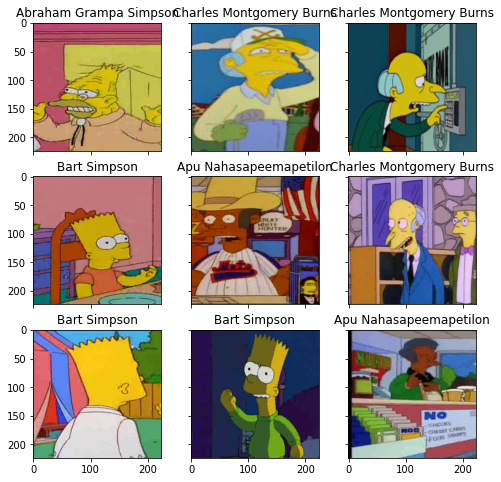

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Building the Neural Network

This baseline architecture will be very simple and is intended to establish a basic understanding and get a simple submission on Kaggle.

Layer descriptions:
1. Input size: 3x224x224
2. Dimensions after the layer: 8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. Output: 96x5x5

In [23]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

Since the provided baseline achieved an F1 score of 0.77 on Kaggle after adjusting batch sizes and epochs, let's proceed with something more advanced right away.

Let's take the pre-trained VGG16 model trained on ImageNet.

In [24]:
my_vgg = models.vgg16(pretrained=True)

In [25]:
my_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# nn ImageNet, there are 1000 classes. Let's count how many classes we have
n_classes = len(np.unique(train_val_labels))
# we will freeze the parameters (weights) that were trained on ImageNet:
for param in my_vgg.parameters ():
  param.requires_grad = False
# the num_features refers to the dimensionality of the feature vector
# that is input to the fully connected (FC) layer of VGG16:
num_features = 25088
# We will replace the fully connected layer with two linear layers and one dropout layer.
# This modification is being made because the performance of a single linear layer was not satisfactory.
my_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True)
)

In [29]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [30]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [31]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [32]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [34]:
n_classes = len(np.unique(train_val_labels))
my_vgg_ready = my_vgg.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(my_vgg_ready)

we will classify :42
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

Let's start training the network.

In [35]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [36]:
history = train(train_dataset, val_dataset, model=my_vgg_ready, epochs=20, batch_size=256)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 4.621395700850663


epoch:   5%|▌         | 1/20 [04:04<1:17:30, 244.77s/it]


Epoch 001 train_loss: 4.6214     val_loss 1.1788 train_acc 0.4061 val_acc 0.6995
loss 0.601638684668232


epoch:  10%|█         | 2/20 [08:10<1:13:37, 245.41s/it]


Epoch 002 train_loss: 0.6016     val_loss 0.7953 train_acc 0.8466 val_acc 0.7981
loss 0.0835687460068024


epoch:  15%|█▌        | 3/20 [12:16<1:09:31, 245.40s/it]


Epoch 003 train_loss: 0.0836     val_loss 0.7327 train_acc 0.9877 val_acc 0.8173
loss 0.013005775373522316


epoch:  20%|██        | 4/20 [16:20<1:05:23, 245.22s/it]


Epoch 004 train_loss: 0.0130     val_loss 0.7381 train_acc 0.9997 val_acc 0.8193
loss 0.0061403270448374785


epoch:  25%|██▌       | 5/20 [20:26<1:01:21, 245.47s/it]


Epoch 005 train_loss: 0.0061     val_loss 0.7545 train_acc 0.9998 val_acc 0.8187
loss 0.004702058349841868


epoch:  30%|███       | 6/20 [24:31<57:11, 245.14s/it]


Epoch 006 train_loss: 0.0047     val_loss 0.7642 train_acc 0.9998 val_acc 0.8214
loss 0.004198870147284232


epoch:  35%|███▌      | 7/20 [28:36<53:08, 245.29s/it]


Epoch 007 train_loss: 0.0042     val_loss 0.7723 train_acc 0.9998 val_acc 0.8223
loss 0.004033000838974089


epoch:  40%|████      | 8/20 [32:41<48:59, 244.95s/it]


Epoch 008 train_loss: 0.0040     val_loss 0.7915 train_acc 0.9998 val_acc 0.8191
loss 0.004524938065164288


epoch:  45%|████▌     | 9/20 [36:45<44:52, 244.81s/it]


Epoch 009 train_loss: 0.0045     val_loss 0.7724 train_acc 0.9998 val_acc 0.8231
loss 0.0030309995402237853


epoch:  50%|█████     | 10/20 [40:49<40:44, 244.46s/it]


Epoch 010 train_loss: 0.0030     val_loss 0.7782 train_acc 0.9997 val_acc 0.8237
loss 0.0021698570115199814


epoch:  55%|█████▌    | 11/20 [44:46<36:20, 242.30s/it]


Epoch 011 train_loss: 0.0022     val_loss 0.8255 train_acc 0.9998 val_acc 0.8162
loss 0.0022101549737673213


epoch:  60%|██████    | 12/20 [48:45<32:10, 241.28s/it]


Epoch 012 train_loss: 0.0022     val_loss 0.8331 train_acc 0.9998 val_acc 0.8187
loss 0.0035523549783123


epoch:  65%|██████▌   | 13/20 [52:44<28:03, 240.46s/it]


Epoch 013 train_loss: 0.0036     val_loss 0.7979 train_acc 0.9999 val_acc 0.8248
loss 0.0018120826961950571


epoch:  70%|███████   | 14/20 [56:43<23:59, 239.98s/it]


Epoch 014 train_loss: 0.0018     val_loss 0.8067 train_acc 0.9999 val_acc 0.8269
loss 0.001070310637178867


epoch:  75%|███████▌  | 15/20 [1:00:42<19:58, 239.76s/it]


Epoch 015 train_loss: 0.0011     val_loss 0.8154 train_acc 0.9999 val_acc 0.8273
loss 0.0010175182525298044


epoch:  80%|████████  | 16/20 [1:04:41<15:57, 239.44s/it]


Epoch 016 train_loss: 0.0010     val_loss 0.9157 train_acc 0.9999 val_acc 0.8135
loss 0.007195200756143799


epoch:  85%|████████▌ | 17/20 [1:08:40<11:58, 239.53s/it]


Epoch 017 train_loss: 0.0072     val_loss 0.8255 train_acc 0.9999 val_acc 0.8244
loss 0.0009709129931159408


epoch:  90%|█████████ | 18/20 [1:12:40<07:59, 239.65s/it]


Epoch 018 train_loss: 0.0010     val_loss 0.8641 train_acc 0.9999 val_acc 0.8206
loss 0.0029457144673319118


epoch:  95%|█████████▌| 19/20 [1:16:39<03:59, 239.38s/it]


Epoch 019 train_loss: 0.0029     val_loss 0.8793 train_acc 0.9999 val_acc 0.8200
loss 0.002276802108828251


epoch: 100%|██████████| 20/20 [1:20:40<00:00, 242.03s/it]


Epoch 020 train_loss: 0.0023     val_loss 0.8518 train_acc 0.9999 val_acc 0.8216


Wow! A training accuracy of 0.9999 is impressive. Let's hope our VGG16 model didn't overfit, and we will soon evaluate this on the F1 score.  
Let's plot the learning curves.

In [54]:
loss, acc, val_loss, val_acc = zip(*history)

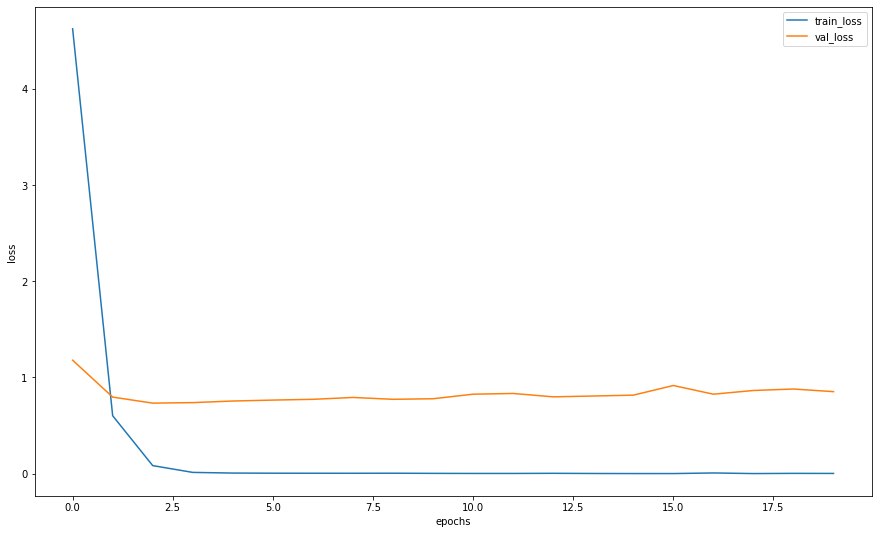

In [55]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## So what should you do now with all of this?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

How to make a submission?
We have a network and its eval() method, which allows us to switch the network into prediction mode.  
It's important to understand that our model has a softmax layer as the final layer, which outputs a vector of probabilities indicating the likelihood of an object belonging to each class. Let's utilize this information.

In [39]:
def predict_one_sample(model, inputs, device=DEVICE):
    """prediction for a single image"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [40]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_vgg_ready, ex_img.unsqueeze(0))

In [41]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(my_vgg_ready, imgs)

In [42]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [43]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [44]:
y_pred

array([ 0, 15,  4,  4, 15,  6,  0,  2,  2,  6, 25,  6,  4,  0,  0,  2,  0,
        4,  4,  2])

Let's calculate the target metric, which is the f1-score, on the validation dataset.

In [45]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average='micro')

0.85

Wow! 0.85 - the best I was able to achieve with my experiments

## Submitting to Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [50]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_vgg_ready, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [51]:
# creating a submission on Google Drive
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)

In [52]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


This is the Simpsons Kaggle leaderboard:  

https://www.kaggle.com/competitions/journey-springfield/leaderboard?search=lyalin

![Kaggle_score](Project_3_pic_2.png)

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)